# Text Classification Engine for Sensor Fusion

First, let us load and preprocess text transcriptions.

**Note**: Running this python script require `nltk` libraries to be set up in prior. Therefore, please download the following dependencies by uncommenting the line `nltk.download()`.

1. `perluniprops`
2. `punkt`

In [122]:
import pandas as pd
import numpy as np
import nltk
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.externals import joblib
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import *
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from yellowbrick.classifier import ClassificationReport
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model
import os.path
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
import tensorflow as tf

Import the dataset and shuffle it.

In [123]:
# nltk.download()
filepath = 'data/fyp_dataset.txt'
df = pd.read_csv(filepath, names=['sentence', 'operation'], sep=', ', engine='python')
df = shuffle(df)
sentences = df['sentence'].values
y = df['operation'].values
print(df)

# df.to_csv(r'data/dataset.txt', sep=', ', index=False, header=False)

                                    sentence  operation
525        Provide the details of this mouse          2
550       What can you say about this laptop          2
414     What are the properties of the chair          2
653                          why didn't guns          3
691                                    gimme          3
548  Can I get information about the monitor          2
71            What is the location of bottle          1
355                    Describe mobile phone          2
369           Give me the details about hand          2
661                                this rule          3
81            What are the locations of pens          1
583  Give me the specification of the laptop          2
198                 Find where the laptop is          1
312                      Is there a pen here          1
442         Explain the features of this cup          2
199                   Find where the book is          1
524        Provide the details of this chair    

Now, we need to **preprocess** the text utterences in the dataset that we possess. This includes:

0. Shuffle the dataset: This is required as this is a manually created dataset according to predefined schema.
1. Removing stopwords.
2. Removing duplicates.
3. Shuffling up data (jumbling up the order)

## Removing Stopwords

`NLTK`, or the Natural Language Toolkit, is a treasure trove of a library for text preprocessing. It’s one of my favorite Python libraries. `NLTK` has a list of stopwords stored in 16 different languages.

However, we use a specific set of stopwords which is apt for our context.

```python
stopwords_list = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "which", "who", "whom", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "against", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "don", "should", "now"]
```

In [124]:
stopwords_list = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "which", "who", "whom", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "against", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "don", "should", "now"]
stopwords_set = set(stopwords_list)

Before removing the stopwords, we need to tokenize the sentences. Afterwards, we remove the stopwords.

In [125]:
def filter_stop_words(sentences):
    filtered_sentences = []
    detokenizer = Detok()
    for sentence in sentences:
        tokenized_sentence = word_tokenize(sentence)
        filtered_sentence = [word for word in tokenized_sentence if word not in stopwords_set]
        filtered_sentence = [] 
        for w in tokenized_sentence: 
            if w not in stopwords_set: 
                filtered_sentence.append(w)
        filtered_sentences.append(filtered_sentence)
    return filtered_sentences
        
filtered_sentences = filter_stop_words(sentences)

The filtered results are as follows (vertically shortened for brevity).

```python
[['What', 'properties', 'cup'], ['Make', 'aware', 'mouse'], ['locate', 'body'], ['Is', 'book'], ['Discover', 'book'], ['Show', 'where', 'bottle'], ['Describe', 'mobile', 'phone'], ['Give', 'account', 'this', 'mobile', 'phone'], ['Help', 'find', 'keyboard'], ['I', 'can', '’', 'find', 'chair'], ['Where', 'I', 'keep', 'chair'], ['Highlight', 'book'], ['What', 'properties', 'monitor'], ['I', 'can', '’', 'find', 'keyboard'], ['Please', 'locate', 'chair'], ['find', 'bob', 'behind'], ['Where', 'I', 'keep', 'monitor'], ['Give', 'account', 'this', 'monitor'], ['look', 'bank'], ['I', 'can', '’', 'find', 'monitor'], ['I', 'need', 'find', 'book'], ['Show', 'where', 'keyboard'], ['please', 'locate', 'pin'], ['Explain', 'properties', 'this', 'book'], ['Discover', 'chair'], ['Explain', 'features', 'this', 'laptop'], ['can', 'hide', 'pain', 'finally'], ['Search', 'pen'], ['What', 'features', 'bottle'], ['Please', 'locate', 'pen'], ['Show', 'properties', 'cup'], ['Show', 'properties', 'this', 'chair'], ['Can', 'help', 'find', 'chair'], ['Explain', 'properties', 'this', 'cup'] 
 
 ...
 
['Is', 'chair'], ["n't", 'guns'], ['Spot', 'cup'], ['Point', 'mobile', 'phone'], ['I', 'can', '’', 'find', 'bottle'], ['Show', 'properties', 'this', 'mouse'], ['Show', 'properties', 'monitor'], ['Search', 'hand']]
```

Let us detokenize the output.

In [126]:
def detokenize(filtered_sentences):
    detokenized_sentences = []
    for sentence in filtered_sentences:
        detokenized_sentences.append(TreebankWordDetokenizer().detokenize(sentence))
    return detokenized_sentences    

detokenized_sentences = detokenize(filtered_sentences)

Now let us assign the detokenized sentences back to the `pandas` dataframe. 

In [127]:
df['filtered_sentence'] = detokenized_sentences
print(df.head())
df.to_csv(r'data/detokenized_dataframe.csv',index = False)

                                 sentence  operation  \
525     Provide the details of this mouse          2   
550    What can you say about this laptop          2   
414  What are the properties of the chair          2   
653                       why didn't guns          3   
691                                 gimme          3   

                  filtered_sentence  
525      Provide details this mouse  
550  What can say about this laptop  
414           What properties chair  
653                        n't guns  
691                             gim  


The field ```filtered_sentence``` is what we feed into the model as inputs. The labels remain the same.

## Building the model.

Here, we will test out several models and test the accuracy parameters, in order to arrive at a final model. We will also use a grid-search methodology for obtaining the best hyperparameters for the chosen model.

However, before this step, we need to understand the distribution of the dataset. For this, we will use `matplotlib` to plot the dataset w.r.t the labels. 

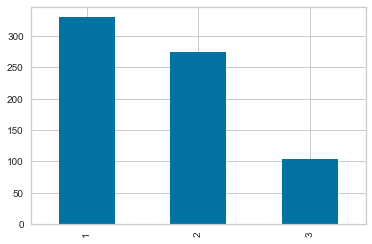

In [128]:
%matplotlib inline
df['operation'].value_counts().plot(kind="bar")

def plot_history(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

First, we test the Multinomial Naive Bayes model.

In [129]:
tags = ['1', '2', '3']

sentences = df['filtered_sentence'].values
y = df['operation']
X_train, X_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

def nb_train(X_train, X_test, y_train, y_test):
    nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    print('Accuracy: %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred,target_names=tags))
    return nb
    
nb_train(X_train, X_test, y_train, y_test)

Accuracy: 0.8932584269662921
              precision    recall  f1-score   support

           1       0.84      1.00      0.91        85
           2       0.96      1.00      0.98        64
           3       1.00      0.34      0.51        29

    accuracy                           0.89       178
   macro avg       0.93      0.78      0.80       178
weighted avg       0.91      0.89      0.87       178



Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Next, we'll try a Linear SVM.

In [130]:
def svc_train(X_train, X_test, y_train, y_test):
    sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    print('Accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred,target_names=tags))
    return sgd

svc_train(X_train, X_test, y_train, y_test)

Accuracy 0.9606741573033708
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        85
           2       0.96      1.00      0.98        64
           3       1.00      0.76      0.86        29

    accuracy                           0.96       178
   macro avg       0.97      0.92      0.94       178
weighted avg       0.96      0.96      0.96       178



Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

Third, we'll try an LSTM. This is based on [Multi-Class Text Classification with LSTM](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17) by Susan Li. We'll visualize the LSTM using `plot_model` and `pydot`.

In [131]:
!pip install pydot

In [132]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 32

def init_tokenizer():
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['filtered_sentence'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return tokenizer

tokenizer = init_tokenizer()

def lstm_train(df, tokenizer):

    X = tokenizer.texts_to_sequences(df['filtered_sentence'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)
    
    Y = pd.get_dummies(df['operation']).values
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
    
    # Oversampling the minority class
    smote = SMOTE('minority')
    X_train, Y_train = smote.fit_sample(X_train, Y_train)
    
#     cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    epochs = 150
    batch_size = 100
    
#     history = model.fit(X_train, Y_train, 
#                         epochs=epochs, batch_size=batch_size, class_weight=cw, 
#                         validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    
    history = model.fit(X_train, Y_train, 
                        epochs=epochs, batch_size=batch_size,
                        validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    
    
    accr = model.evaluate(X_test,Y_test)
    
    y_pred = model.predict(X_test)
    
    print(model.summary())
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
    plot_model(model, to_file='model.png')
    return model, history

model, history = lstm_train(df, tokenizer)

Found 164 unique tokens.
Shape of data tensor: (709, 250)


/home/dasun/anaconda3/envs/dm/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 624 samples, validate on 70 samples
Epoch 1/150
624/624 [==============================] - 3s 4ms/step - loss: 1.6549 - accuracy: 0.3846 - val_loss: 1.7274 - val_accuracy: 0.0000e+00
Epoch 2/150
624/624 [==============================] - 2s 3ms/step - loss: 1.5550 - accuracy: 0.3846 - val_loss: 1.7203 - val_accuracy: 0.0000e+00
Epoch 3/150
624/624 [==============================] - 2s 3ms/step - loss: 1.4676 - accuracy: 0.3846 - val_loss: 1.6346 - val_accuracy: 0.0000e+00
Epoch 4/150
624/624 [==============================] - 2s 3ms/step - loss: 1.3930 - accuracy: 0.3862 - val_loss: 1.4756 - val_accuracy: 0.0000e+00
Epoch 5/150
624/624 [==============================] - 2s 3ms/step - loss: 1.3205 - accuracy: 0.4359 - val_loss: 1.4353 - val_accuracy: 0.0000e+00
Epoch 6/150
624/624 [==============================] - 2s 3ms/step - loss: 1.2520 - accuracy: 0.4343 - val_loss: 1.4384 - val_accuracy: 0.0000e+00
Epoch 7/150
624/624 [==============================] - 2s 3ms/step - loss

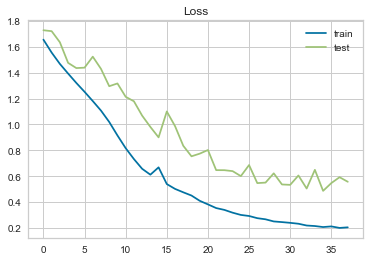

In [133]:
plot_history(history) 

Model architecture is shown below.

<div align="center"><img src="model.png" /></div>

## Test the Models

Now, let us test the models. We start with the LSTM.

### Testing LSTM 

In [134]:
new_command = ['Track the pencil']
filtered_commands = filter_stop_words(new_command)
seq = tokenizer.texts_to_sequences(filtered_commands)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

labels = ['Locate', 'Describe', 'No_Op']
print("Predicted vector: ", pred, " Predicted Class: " ,labels[np.argmax(pred)])

Predicted vector:  [[0.79105943 0.00257285 0.20636767]]  Predicted Class:  Locate


In [137]:
df.to_csv(r'data/dataset.txt', header=None, index=None, sep=',', mode='a')
model.save('lstm.h5')

In [ ]:
def load_model(model_path ):
    model = model.load(model_path)